In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from PIL import Image

# Pre-process the data

In [2]:
excel_path = "../dataset_sheet.xlsx"
data_df = pd.read_excel(excel_path, sheet_name='Copy of Sheet1')

data_df = data_df[['image', 'Matt', 'Laura', 'Megan', 'Vivian']]
data_df.head()

,image,Matt,Laura,Megan,Vivian
0,https://www.forever21.com/us/2001311824.html,6.0,3.0,4.0,NaN
1,https://codibook.net/item/9128545?viewMode=sho...,7.0,NaN,NaN,7.0
2,https://www.forever21.com/us/2001311729.html,NaN,NaN,3.0,NaN
3,https://codibook.net/item/9210572?viewMode=sho...,NaN,NaN,NaN,1.0
4,https://codibook.net/item/8985302?viewMode=sho...,NaN,4.0,NaN,NaN


In [8]:
img_url_to_idx = {}
for idx, row in data_df.iterrows():
    img_url = row['image']
    img_url_to_idx[img_url] = idx

In [20]:
def display_recommendations(recommendations, title, num_items=5):
    """
    Display images of recommended items in a row with their predicted ratings
    """
    fig = plt.figure(figsize=(20, 7))
    plt.suptitle(title, fontsize=16)

    for idx, (item, rating) in enumerate(recommendations[:num_items]):
        img_name = img_url_to_idx[item]
        img_path = os.path.join('../dataset', str(img_name) + '.png')

        plt.subplot(1, 5, idx + 1)

        try:
            # Load and display image
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            plt.text(0.5, 0.5, 'Image not found', ha='center', va='center')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# User-based collaborative filtering

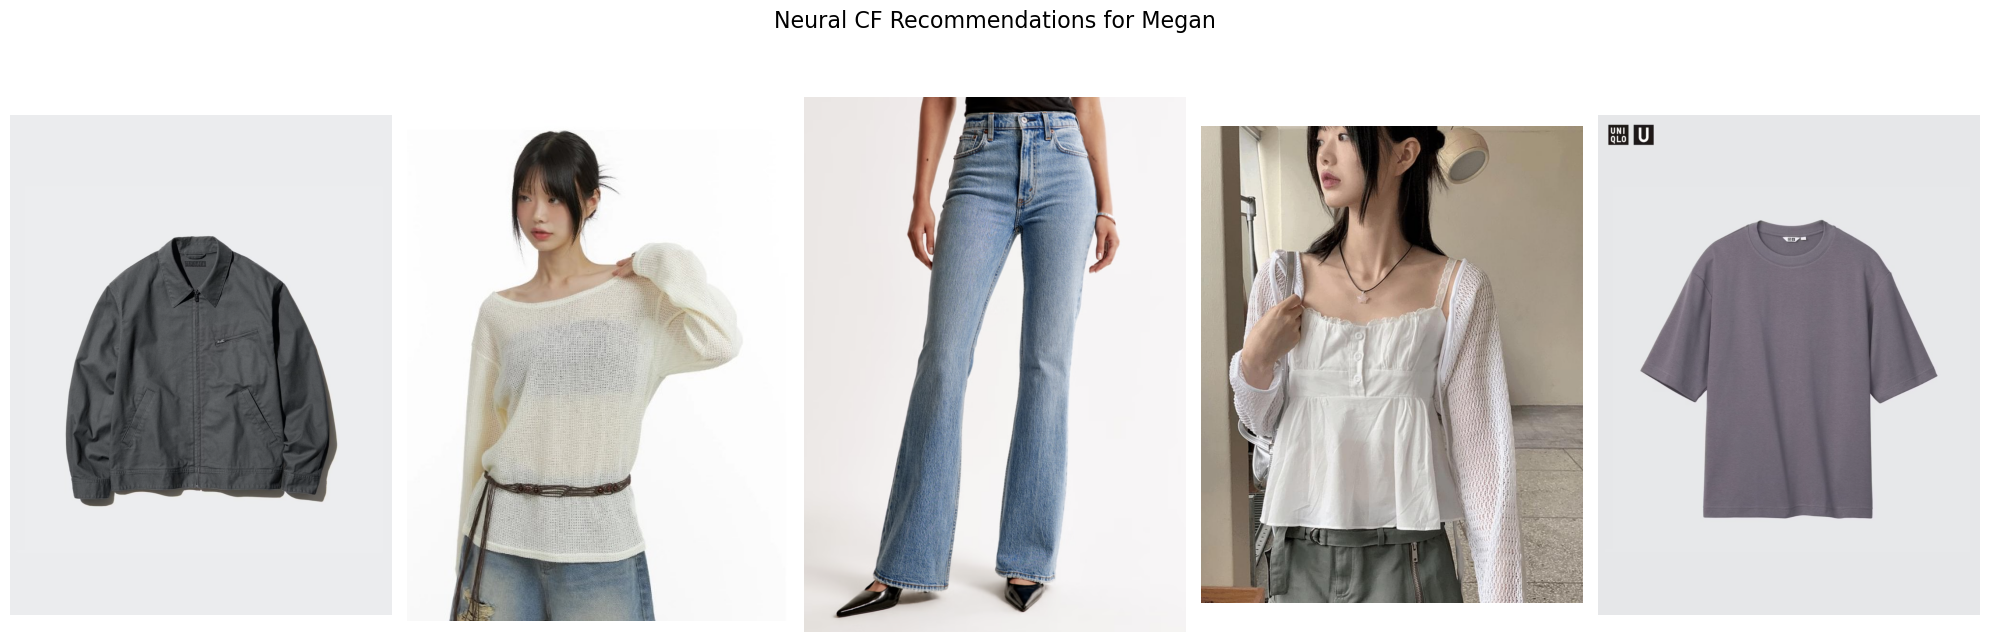


Recommendations for Megan:
Item: https://www.uniqlo.com/us/en/products/E463857-000/00?colorDisplayCode=57&sizeDisplayCode=004
Item: https://www.whitehouseblackmarket.com/store/product/v-neck-open-stitch-sequin-sweater/570380539?inseam=regular&sizeType=regular&color=6457&catId=cat7029280&collectionId=category&queryId=5774f7fad7494d66a01424a0da892550&indexName=prod_whbm_products
Item: https://www.abercrombie.com/shop/us/p/cable-knit-turtleneck-sweater-58399420?seq=01&prodvm=recommendations-CoBuy_PDP_Updated_Copy-63454
Item: https://www.uniqlo.com/us/en/products/E465185-000/00?colorDisplayCode=02&sizeDisplayCode=003
Item: https://www.uniqlo.com/us/en/products/E471808-000/00?colorDisplayCode=19&sizeDisplayCode=003


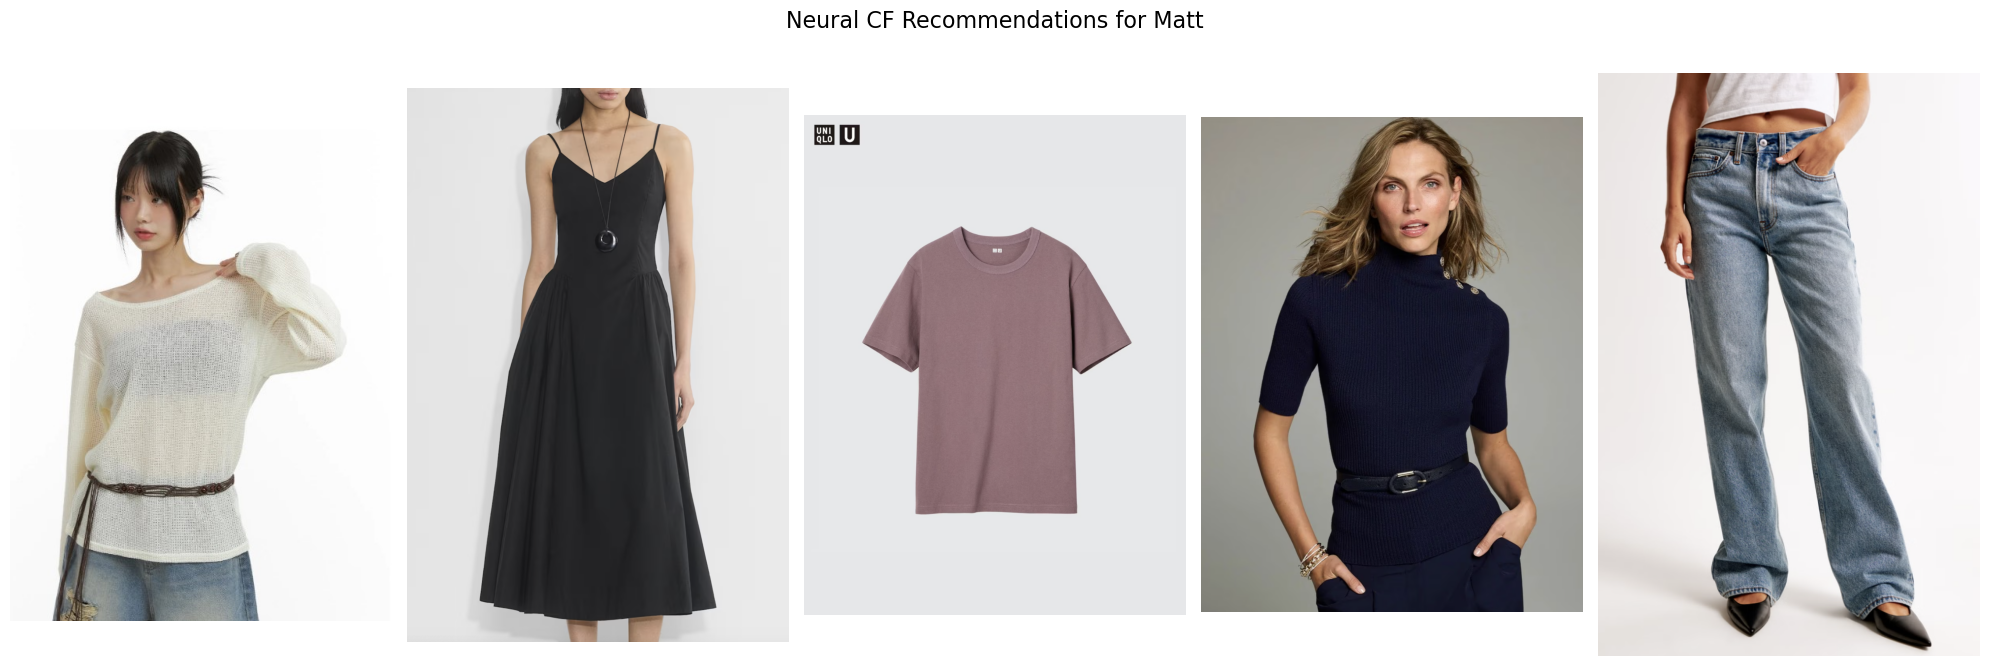

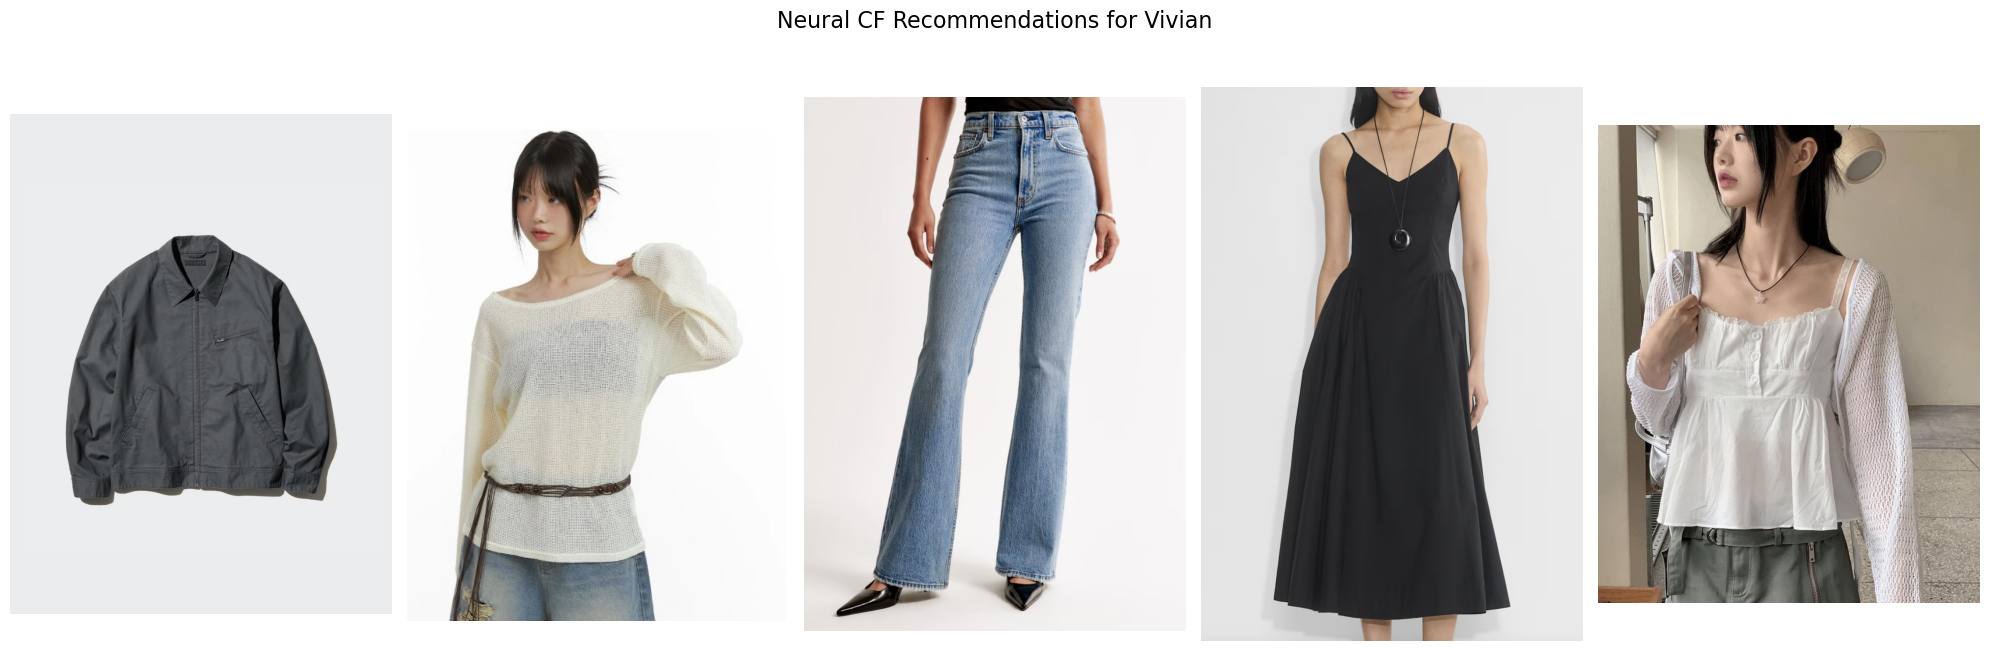

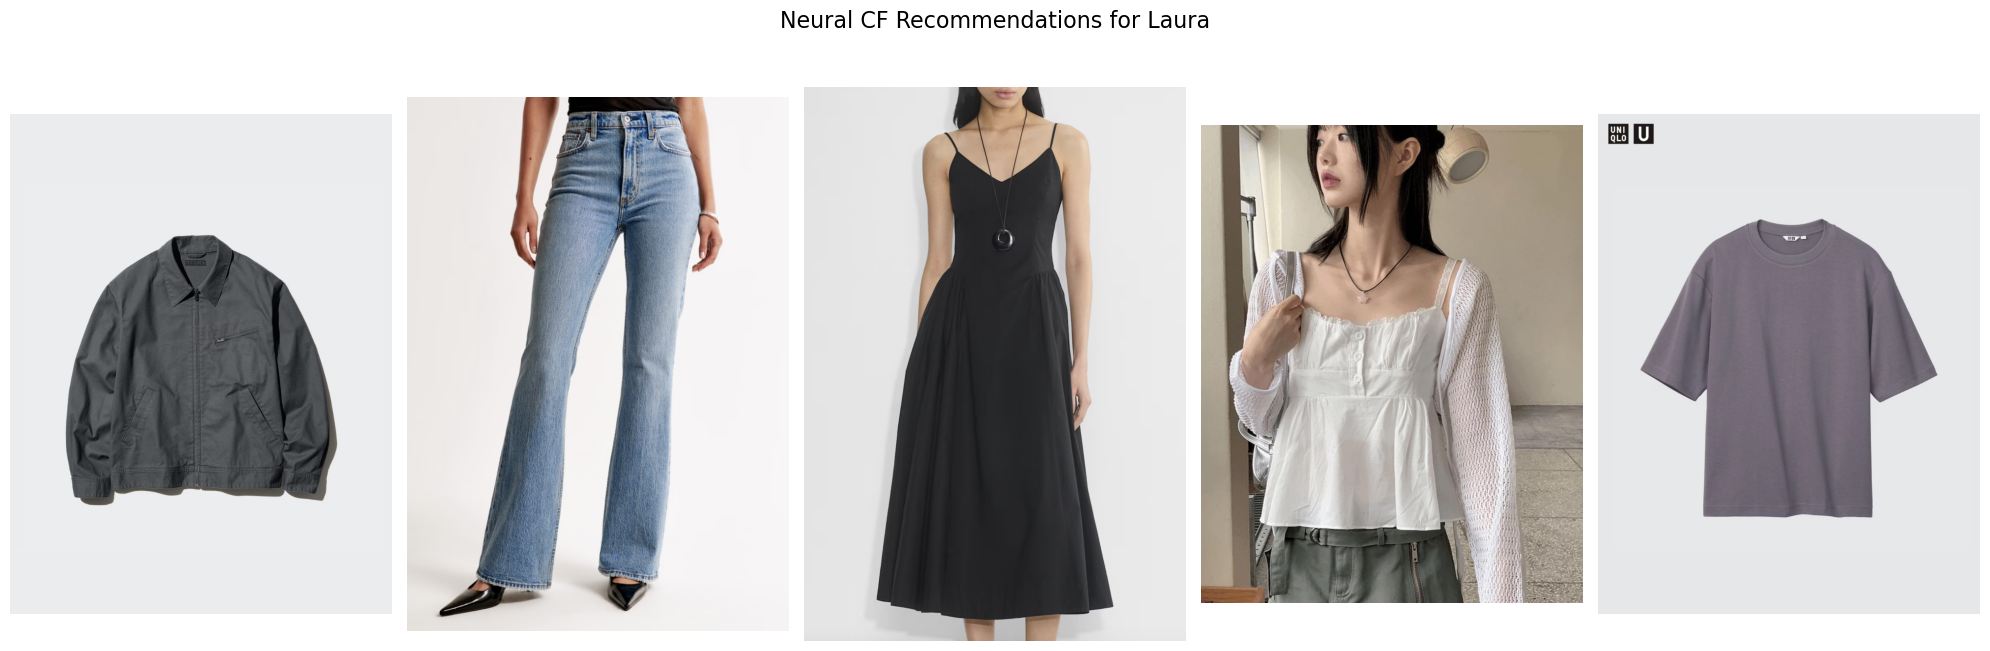

In [22]:
# Create user-item matrix with ratings as value
melted_df = data_df.melt(id_vars=['image'], var_name='user', value_name='rating')
user_item_matrix = melted_df.pivot_table(index='user', columns='image', values='rating')

# Drop NaNs only when calculating similarity
user_item_matrix_sparse = user_item_matrix.copy()
user_similarity = pd.DataFrame(cosine_similarity(user_item_matrix_sparse.fillna(0)),
                               index=user_item_matrix.index,
                               columns=user_item_matrix.index)

def get_user_recommendations(user, n_recommendations=5):
    user_sim_scores = user_similarity.loc[user]
    similar_users = user_sim_scores.drop(user).sort_values(ascending=False)

    user_unrated = user_item_matrix.loc[user][user_item_matrix.loc[user].isna()].index

    recommendations = []
    for item in user_unrated:
        item_ratings = user_item_matrix[item]

        rated_by_similar = item_ratings[similar_users.index].dropna()
        relevant_similarities = similar_users[rated_by_similar.index]

        weighted_sum = (rated_by_similar * relevant_similarities).sum()
        similarity_sum = relevant_similarities.sum()

        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
            recommendations.append((item, predicted_rating))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n_recommendations]


megan_recommendations = get_user_recommendations('Megan')
display_recommendations(megan_recommendations,
                      "Neural CF Recommendations for Megan")
print("\nRecommendations for Megan:")
for item, rating in megan_recommendations:
    print(f"Item: {item}")

matt_recommendations = get_user_recommendations('Matt')
display_recommendations(matt_recommendations,
                      "Neural CF Recommendations for Matt")

vivian_recommendations = get_user_recommendations('Vivian')
display_recommendations(vivian_recommendations,
                      "Neural CF Recommendations for Vivian")

vivian_recommendations = get_user_recommendations('Laura')
display_recommendations(vivian_recommendations,
                      "Neural CF Recommendations for Laura")

# Item-based collaborative filtering

In [ ]:
# Calculate item-item similarity matrix using cosine similarity
item_similarity = pd.DataFrame(cosine_similarity(user_item_matrix.T.fillna(0)),
                             index=user_item_matrix.columns,
                             columns=user_item_matrix.columns)

def get_item_recommendations(user, n_recommendations=5):
    # Get items that the user has rated
    user_rated = user_item_matrix.loc[user].dropna()

    # Get items that the user hasn't rated
    user_unrated = user_item_matrix.loc[user][user_item_matrix.loc[user].isna()].index

    # Calculate predicted ratings
    recommendations = []
    for item in user_unrated:
        item_sim_scores = item_similarity.loc[item, user_rated.index]

        # Weights
        weighted_sum = (user_rated * item_sim_scores).sum()
        similarity_sum = item_sim_scores.sum()

        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
            recommendations.append((item, predicted_rating))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n_recommendations]

laura_item_recommendations = get_item_recommendations('Laura')
print("\nItem-based recommendations for Laura:")
for item, rating in laura_item_recommendations:
    print(f"Item: {item}")

matt_item_recommendations = get_item_recommendations('Vivian')
print("\nItem-based recommendations for Vivian:")
for item, rating in matt_item_recommendations:
    print(f"Item: {item}")



Item-based recommendations for Laura:
Item: https://codibook.net/item/9210572?viewMode=shopThumbnail\
Item: https://www.uniqlo.com/us/en/products/E477753-000/00?colorDisplayCode=01&sizeDisplayCode=004
Item: https://www.abercrombie.com/shop/us/p/essential-tuckable-baby-tee-52230833?categoryId=6570723&faceout=model&seq=02&afsource=social+proofing
Item: https://www.aritzia.com/us/en/product/leda-ponte-dress/123027.html?dwvar_123027_color=1274
Item: https://www.uniqlo.com/us/en/products/E475296-000/00?colorDisplayCode=69&sizeDisplayCode=008

Item-based recommendations for Vivian:
Item: https://www.abercrombie.com/shop/us/p/high-rise-90s-relaxed-jean-57178819?categoryId=12203&faceout=model&seq=99
Item: https://www.abercrombie.com/shop/us/p/high-rise-vintage-flare-jean-57065843?faceout=model&seq=08
Item: https://www.aritzia.com/us/en/product/clara-merino-wool-sweater/121809.html?dwvar_121809_color=34735
Item: https://www.aritzia.com/us/en/product/maria-merino-wool-sweater/121814.html?dwvar_

# Neural collaborative filtering

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Convert data to numeric indices
users = user_item_matrix.index.unique()
items = user_item_matrix.columns.unique()

user_to_idx = {user: idx for idx, user in enumerate(users)}
item_to_idx = {item: idx for idx, item in enumerate(items)}

# Create training data
ratings_data = []
for user in users:
    user_ratings = user_item_matrix.loc[user].dropna()
    for item, rating in user_ratings.items():
        ratings_data.append([
            user_to_idx[user],
            item_to_idx[item],
            rating
        ])

ratings_data = torch.tensor(ratings_data)

# Split into train/test
train_data, test_data = train_test_split(ratings_data, test_size=0.2, random_state=42)

# Neural CF model
class NCF(nn.Module):
    def __init__(self, n_users, n_items, n_factors=8, hidden_layers=[64, 32]):
        super().__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.item_embedding = nn.Embedding(n_items, n_factors)

        # MLP layers
        layers = []
        input_size = n_factors * 2
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_layers[-1], 1)

    def forward(self, user_idx, item_idx):
        user_embed = self.user_embedding(user_idx)
        item_embed = self.item_embedding(item_idx)

        x = torch.cat([user_embed, item_embed], dim=1)
        x = self.mlp(x)
        rating = self.output(x)
        return rating.squeeze()

# Initialize model
model = NCF(len(users), len(items))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
n_epochs = 10
batch_size = 64

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    # Create batches
    indices = torch.randperm(len(train_data))
    for start_idx in range(0, len(train_data), batch_size):
        batch_indices = indices[start_idx:start_idx+batch_size]
        batch = train_data[batch_indices]

        user_idx = batch[:, 0].long()
        item_idx = batch[:, 1].long()
        ratings = batch[:, 2].float()

        # Forward pass
        predicted_ratings = model(user_idx, item_idx)
        loss = criterion(predicted_ratings, ratings)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(train_data) // batch_size)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

# Function to get recommendations using NCF
def get_ncf_recommendations(user, n_recommendations=5):
    model.eval()
    user_idx = user_to_idx[user]

    # Get items the user hasn't rated
    rated_items = set(user_item_matrix.loc[user].dropna().index)
    unrated_items = [item for item in items if item not in rated_items]

    # Predict ratings for unrated items
    predictions = []
    for item in unrated_items:
        item_idx = item_to_idx[item]
        with torch.no_grad():
            pred_rating = model(
                torch.tensor([user_idx]),
                torch.tensor([item_idx])
            ).item()
        predictions.append((item, pred_rating))

    # Sort and return top recommendations
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n_recommendations]

# Get recommendations for Laura using NCF
laura_ncf_recommendations = get_ncf_recommendations('Laura')
print("\nNeural CF recommendations for Laura:")
for item, rating in laura_ncf_recommendations:
    print(f"Item: {item}")

# Get recommendations for Matt using NCF
matt_ncf_recommendations = get_ncf_recommendations('Matt')
print("\nNeural CF recommendations for Matt:")
for item, rating in matt_ncf_recommendations:
    print(f"Item: {item}")


ZeroDivisionError: float division by zero